# A visualisation of the Birmingham 'Scoots' data

Scoots are the cables often seen laid across roads. They are sensors that capture the speed of vehicles crossing them. 

In [1]:
%matplotlib inline

import pymongo
import pandas as pd
import numpy as np

import matplotlib.cm
import matplotlib.pyplot as plt

from pymongo import MongoClient
from mpl_toolkits.basemap import Basemap

In [146]:
client = MongoClient('localhost', 27017)

In [147]:
client.database_names()

['admin', 'config', 'local', 'test', 'users']

In [4]:
db = client.test
collection = db.sensor

dictholder = {}

In [5]:
for it in collection.find():
    dictholder[str(it['_id'])] = {key:it[key] for key in it.keys() - {'_id'}}

In [6]:
df = pd.DataFrame(dictholder).T.reset_index()
df.columns = ['sensor'] + list(df.columns[1:])

In [7]:
df.head()

sensor bearing compass easting          last_update lat  \
0  5acf66f1bd8a660c745e00f8                       0  2018-02-12 12:20:55       
1  5acf66f1bd8a660c745e00f9                       0  2016-01-05 16:41:42       
2  5acf66f1bd8a660c745e00fa                       0  2018-02-12 12:20:55       
3  5acf66f1bd8a660c745e00fb                  410459  2017-06-01 09:07:39       
4  5acf66f1bd8a660c745e00fc                       0  2017-08-08 22:49:34       

  location lon northing scoot_id system_code_number  
0                     0      201            N24211B  
1                     0      692            N63132B  
2                     0      203            N24211E  
3                290130      850            N74212Y  
4                     0      898            N81132C

In [8]:
df.groupby('scoot_id').first().shape

(1077, 10)

In [9]:
df[df['lon']!=''].shape

(360, 11)

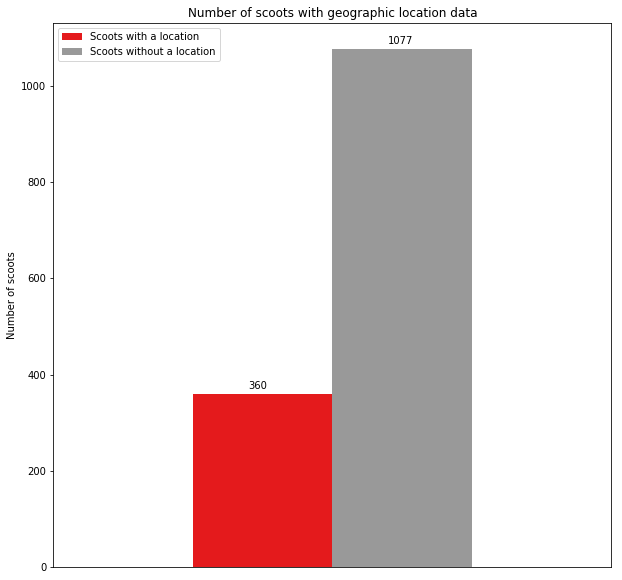

In [10]:
fig, ax = plt.subplots(figsize=((10,10)))
pd.DataFrame({'Scoots without a location':1077, 'Scoots with a location':360}, index=[1]).plot(kind='bar', ax=ax, cmap='Set1')

ax.set_ylabel('Number of scoots')
ax.set_title('Number of scoots with geographic location data')
ax.set_xticks([])
ax.text(0.1, 1087, '1077')
ax.text(-0.15, 370, '360');

In [11]:
lons = []
lats = []
for row in df[df['lon']!=''].itertuples():
    lons.append(row.lon)
    lats.append(row.lat)

C:\Users\James\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\James\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


Wall time: 1min 21s


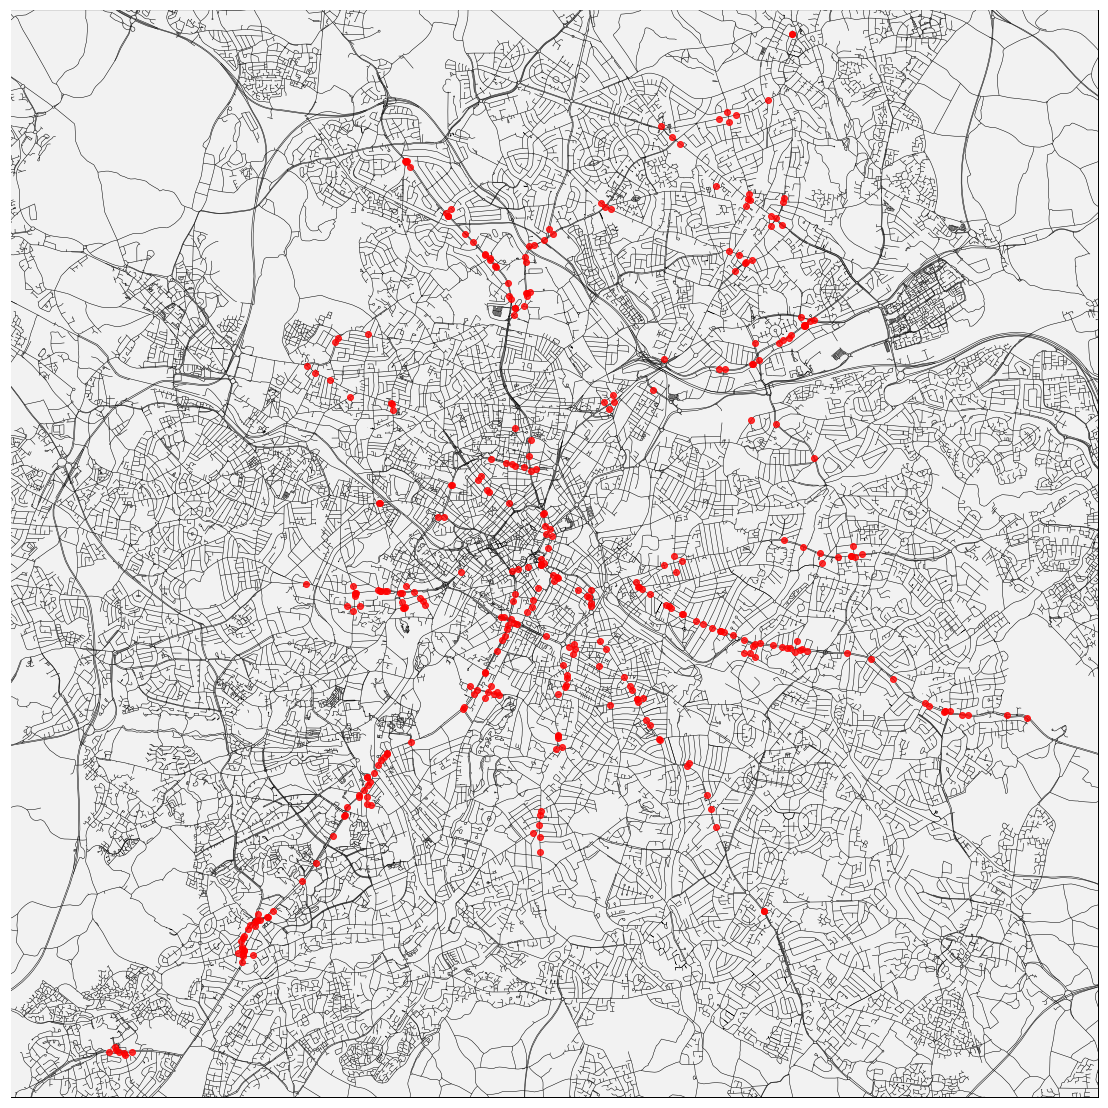

In [12]:
%%time
fig= plt.figure(figsize=(20,20))


m = Basemap(resolution='c',
            projection='tmerc',
            lat_0=52.4782, lon_0=-1.889, width=20000, height = 20000)
            #llcrnrlon=-2, llcrnrlat=51.418, urcrnrlon=-0.8, urcrnrlat=52.504)

m.drawmapboundary(fill_color='white', zorder=0)
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec', zorder=1)
m.drawcoastlines(zorder=2)
#m.readshapefile("D:\Html pages\Distribution\Areas", 'areas', zorder=3)
m.readshapefile(r"D:\Html pages\roads", 'roads', zorder=4)

#y, x = m(52.4782, -1.889)

m.plot(lons,lats, 'ko', latlon=True, zorder=10, color='red', alpha=0.8);

In [148]:
db = client.users
scoots = db.scoots_data_MSC

In [149]:
scoots.count()

211194123

In [150]:
scoots.find_one()

{'_id': ObjectId('5ad25fd14886f224963c1413'),
 'congestion': 0,
 'entry_id': 5149162,
 'flow': 0,
 'occupancy': 0,
 'scoot_id': 31,
 'speed': 0,
 'travel_time': 0,
 'travel_time_status': 0,
 'travel_time_type': 1,
 'update_time': '2015-05-26 05:57:55'}

In [16]:
actives = df[df['lon']!='']['scoot_id'].tolist()

In [153]:
active_dict_day2 = {}
active_dict_dayhour2 = {}

for scoot in todo:

    
    df2 = pd.DataFrame.from_records(scoots.find({'scoot_id':scoot}))
    df2['update_time'] = pd.to_datetime(df2['update_time'])
    df2['hour'] = df2['update_time'].apply(lambda x : x.hour)
    df2['date'] = df2['update_time'].apply(lambda x : x.date())
    df2['weekday'] = df2['date'].apply(lambda x: x.weekday())
    
    rush = df2[ ((df2['hour'] == 8 ) | (df2['hour'] == 9)) & (df2['speed'] != 80) ].copy()
    rush['minute'] = pd.to_datetime(rush['update_time']).apply(lambda x: x.minute)
    
    active_dict_day2[scoot] = rush.groupby(['weekday'])['speed'].mean().to_dict()
    active_dict_dayhour2[scoot] = rush.groupby(['weekday','hour','minute'])['speed'].mean().to_dict()

In [65]:
todo = list(set(actives).difference(set(avgs.index.tolist())))

In [182]:
avgday = pd.read_csv(r"E:\DataSets\BirminghamScoots\avgDayFull.csv")
avgdayhour = pd.read_csv(r"E:\DataSets\BirminghamScoots\avgDayHourFull.csv")

avgday = avgday.T.sort_index()[:-3] #remove merge artifacts

In [207]:
avgs = avgday.copy()

In [208]:
avgs['Sun_to_Mon'] = 100* avgs[0] / avgs[6] 

In [41]:
avgs = avgs.sort_values(by='Sun_to_Mon')

In [211]:
avgs.iloc[0,:-1]

0    37.949807
1    39.478261
2    38.846154
3    39.407547
4    39.304348
5    40.291028
6    36.647343
Name: 1, dtype: float64

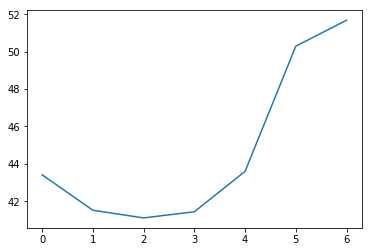

In [217]:
avgs.iloc[2,:-1].plot()

In [218]:
def Loss(stm):
    return max(100 - stm,0)

In [219]:
avgs['speedloss'] = avgs['Sun_to_Mon'].apply(Loss)

In [220]:
avgs

0          1          2          3          4          5  \
1     37.949807  39.478261  38.846154  39.407547  39.304348  40.291028   
10    26.800359  26.618552  26.611765  26.518290  26.411765  25.735522   
1000  43.409506  41.513808  41.104824  41.434282  43.596215  50.295217   
1010  51.586535  50.866089  50.547270  51.013527  51.230270  54.770957   
1015  33.317670  31.189224  31.583010  32.961951  35.381424  44.920589   
1017  22.538896  20.356864  20.649961  20.582383  22.703058  40.604687   
1018  45.107421  44.818285  45.461185  45.173469  44.780334  50.028508   
1019  48.594575  48.627848  48.553689  48.748527  48.574895  50.308160   
1021  29.387230  28.276738  28.451613  28.663396  29.036346  36.304882   
1022  30.215065  28.584337  28.452874  29.035944  29.730731  37.781488   
1023  38.743869  37.868235  36.925050  37.796340  38.680416  44.930647   
1025  33.489515  32.917758  33.047936  33.467343  34.383517  36.169220   
1027  48.568879  48.079928  48.053246  48.364641  49.047076  53.084512   
1034  36.955668  36.270379  35.662529  35.448537  36.120668  39.815858   
1036  30.944323  29.827240  28.561969  28.106232  30.545486  39.717140   
1041  34.307908  33.318043  33.123939  33.176928  33.417354  42.135046   
105   15.043310  13.950447  14.334155  14.201939  13.718651  17.001648   
106   22.607941  21.293348  21.491155  21.485813  21.183026  25.576708   
1063  19.656153  18.842505  18.972587  19.025660  19.160227  26.214449   
1066  30.326378  29.545688  29.835537  29.808219  29.926060  32.858203   
1068  34.379534  33.971009  34.176096  34.195554  34.248422  36.544908   
1069  34.800441  35.359347  33.875231  34.223156  35.211440  34.062500   
1071  31.781490  31.083890  31.137366  30.923490  30.928618  36.933445   
1072  25.071212  23.287337  23.120960  23.701843  25.073832  38.198811   
1073  25.929116  22.669176  23.976822  23.627369  26.006377  42.332083   
1074  36.117726  35.644017  35.715863  35.595238  35.744722  38.240490   
1077  30.364571  28.774315  28.767477  28.896552  29.903371  38.339085   
1078  42.358289  41.619286  41.642619  41.682976  41.883698  45.794562   
1079  35.220475  34.663133  34.698561  34.762735  34.881169  36.935142   
109    3.624221   3.921202   3.775709   3.821815   3.919231   3.274380   
...         ...        ...        ...        ...        ...        ...   
939   32.996532  32.561056  32.213757  32.156013  32.349028  37.948387   
94    31.108873  30.792952  30.597139  30.854184  30.775723  30.303949   
940   43.436552  41.676895  41.270901  42.295907  43.376980  49.141746   
942   35.996202  34.039006  34.324771  33.543298  35.700660  42.670022   
949   18.784187  19.384029  20.130751  19.764059  19.547582  16.785798   
95    26.642496  26.451426  26.643714  26.523622  26.454998  27.623499   
951   15.307894  14.306017  15.447910  14.922060  15.066304  18.308047   
953   34.454060  33.277994  33.100590  33.112340  34.851712  40.575577   
957   36.131313  35.072202  33.214559  35.661654  35.537255  41.880952   
958   37.354227  35.743619  34.916573  35.686892  36.967320  46.135879   
960   20.980864  21.025429  21.097421  21.204875  21.235690  20.686427   
968   35.471819  34.212474  34.821323  35.004203  35.507432  41.902480   
969   41.360269  39.202520  39.855195  39.619811  40.291076  48.579413   
970   32.926996  31.615150  31.536217  31.890995  33.553223  37.493347   
971   35.092426  33.642381  33.871471  33.936501  33.996696  42.137815   
972   36.184152  36.002131  35.475542  35.424876  35.939331  42.561694   
975   35.078919  34.350355  34.349948  34.045406  33.794704  38.956457   
976   16.792790  17.036464  17.591457  17.015061  17.214430  16.879222   
977   18.803377  16.930478  16.992766  16.749647  16.826572  35.929806   
982   37.482412  37.074439  37.287460  37.230105  37.125389  39.275815   
983   36.151361  34.195682  34.315295  34.511975  36.844648  44.666515   
985   33.420807  32.480732  32.426349  32.903418  33.836355  41.704097   
986   34.782266  3

In [221]:
sc = pd.read_csv(r"E:\DataSets\BirminghamScoots\scoots_MSC.csv")

In [222]:
sc.index = sc['scoot_id'].tolist()
sc.index = [str(i) for i in sc.index] #int to str

In [242]:
full = avgs.join(sc)

In [245]:
latlons = [] 
for row in full.itertuples():
    latlons.append((row.lat, row.lon, row.speedloss))

In [246]:
full['latlons'] = latlons

In [248]:
def plot_scoots(latlon):
    lat = latlon[0]
    lon = latlon[1]
    speedloss = latlon[2]
    size = speedloss/2
    m.plot(lon, lat, 'ko', markersize=size, color='#444444', alpha=0.8, latlon=True)

C:\Users\James\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\James\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


Wall time: 1min 25s


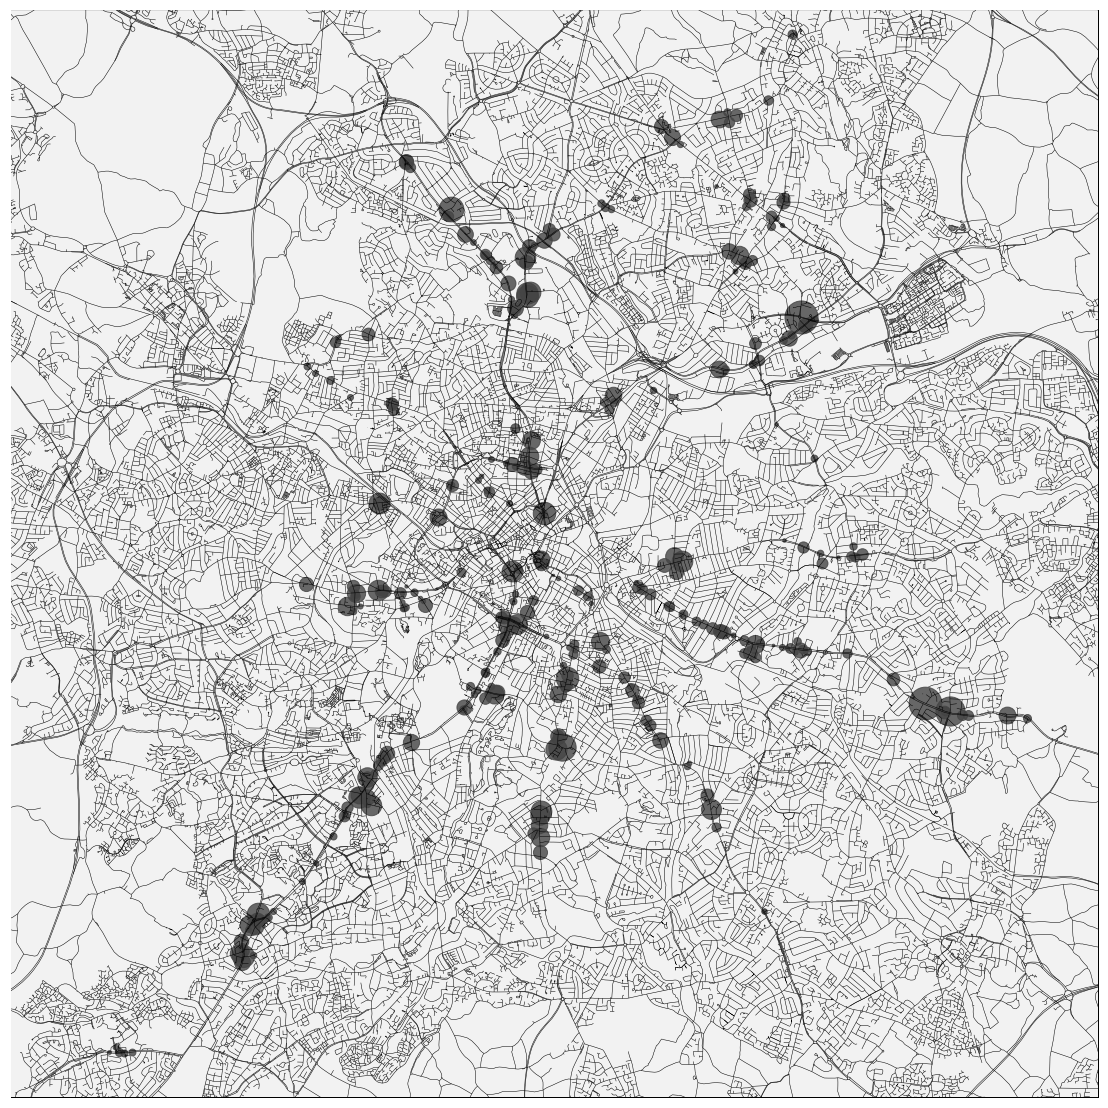

In [249]:
%%time
fig= plt.figure(figsize=(20,20))


m = Basemap(resolution='c',
            projection='tmerc',
            lat_0=52.4782, lon_0=-1.889, width=20000, height = 20000)
            #llcrnrlon=-2, llcrnrlat=51.418, urcrnrlon=-0.8, urcrnrlat=52.504)

m.drawmapboundary(fill_color='white', zorder=0)
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec', zorder=1)
m.drawcoastlines(zorder=2)
m.readshapefile(r"D:\Html pages\roads", 'roads', zorder=4)

full['latlons'].apply(plot_scoots)

In [256]:
full.sort_values(by='speedloss')

0          1          2          3          4          5  \
1     37.949807  39.478261  38.846154  39.407547  39.304348  40.291028   
853   38.355674  38.215558  38.456820  38.540854  38.355964  40.572650   
9     35.761095  35.225745  34.731959  36.143817  34.559250  21.997143   
127    2.845869   2.820000   2.873281   2.882157   2.918815   1.979572   
128    3.101756   3.072843   3.086097   3.051105   2.984770   1.639671   
131   12.870869  13.813038  13.939394  14.286247  13.578352   5.691919   
135    7.307720   7.641459   7.692333   7.616899   7.228739   3.502627   
818   30.577138  30.571582  30.674947  30.150161  30.911514  34.080054   
813   29.323426  29.212496  29.070315  29.083216  29.123882  31.893557   
759   52.156954  52.139344  51.638984  51.661815  51.749303  46.454291   
59    32.043887  32.241379  31.436170  32.041874  32.607114  34.235659   
580   23.593035  23.707612  22.815934  23.533868  23.007299  21.272000   
109    3.624221   3.921202   3.775709   3.821815   3.919231   3.274380   
949   18.784187  19.384029  20.130751  19.764059  19.547582  16.785798   
197   29.451045  29.567586  29.396605  28.250609  27.563605  27.594310   
960   20.980864  21.025429  21.097421  21.204875  21.235690  20.686427   
2     26.098495  27.560408  27.995614  26.091040  26.801316  22.766337   
976   16.792790  17.036464  17.591457  17.015061  17.214430  16.879222   
436   13.141202  14.324157  14.510062  14.288040  13.361148   7.942640   
349   27.736276  28.015808  27.451483  27.560606  27.249764  28.879137   
345   30.377056  31.391856  31.121224  31.195446  30.239155  26.325714   
25    43.078999  43.104205  43.273350  43.153145  43.055187  43.112344   
94    31.108873  30.792952  30.597139  30.854184  30.775723  30.303949   
820   27.191328  27.397274  26.773572  27.195122  27.460371  27.958869   
22    38.233318  38.266390  38.172149  38.174414  37.976334  37.636735   
308   31.348259  31.385926  31.308796  31.184685  31.259679  31.022727   
186   41.728539  41.302213  41.442142  40.802015  40.732467  42.971391   
114   34.655462  34.880633  35.254854  34.360019  33.787822  34.263619   
290   40.885936  40.698389  40.706613  41.035807  41.007053  43.808171   
324   26.647954  26.467180  26.424273  26.358133  26.407383  27.997012   
...         ...        ...        ...        ...        ...        ...   
737   25.306572  24.293301  23.880404  24.311610  25.063933  35.000726   
545   29.567254  26.756883  26.999584  27.816399  30.955876  43.455826   
246   25.787599  23.667770  23.035918  23.441445  28.002014  36.061002   
170   19.232496  18.172312  17.341293  18.250758  17.419078  23.894195   
284   22.276786  21.883721  22.076440  22.090329  22.413946  30.051335   
273   22.457028  20.489016  20.112785  20.984629  23.224710  34.340043   
274   28.275037  25.901825  25.099964  26.087054  28.189035  43.455092   
215   28.122781  26.016462  25.198107  25.867792  26.902768  41.549265   
300   25.588000  23.813620  24.370370  24.318878  26.552833  40.532145   
1072  25.071212  23.287337  23.120960  23.701843  25.073832  38.198811   
441   29.008403  26.555848  25.745881  27.225634  31.642053  46.966158   
669   26.064230  24.321041  24.102030  25.101184  26.337143  29.624800   
992   22.517627  20.276617  20.515553  20.852376  21.733897  34.647020   
177   18.462035  17.683484  17.437799  17.654179  17.535797  23.755406   
342   25.605692  23.751519  23.089401  23.034051  25.646728  38.342141   
668   23.315085  23.044721  23.586831  24.185337  24.696748  38.897355   
421   21.645697  19.353339  18.295288  19.578881  21.930213  33.666950   
85    23.800081  21.995945  21.366563  21.925667  23.724693  34.573349   
756   26.312414  24.522443  24.797583  25.234830  26.517940  40.891787   
297   26.497242  24.699174  25.024644  26.801103  31.301606  44.895612   
667   28.583577  26.176089  26.532166  27.691149  30.507221  46.367790   
321   29.071233  25.923111  25.896739  25.262712  26.544493  45.385279   
81    19.015818  1

In [253]:
plotme = avgs.iloc[:, :-2]

In [254]:
labels= ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']

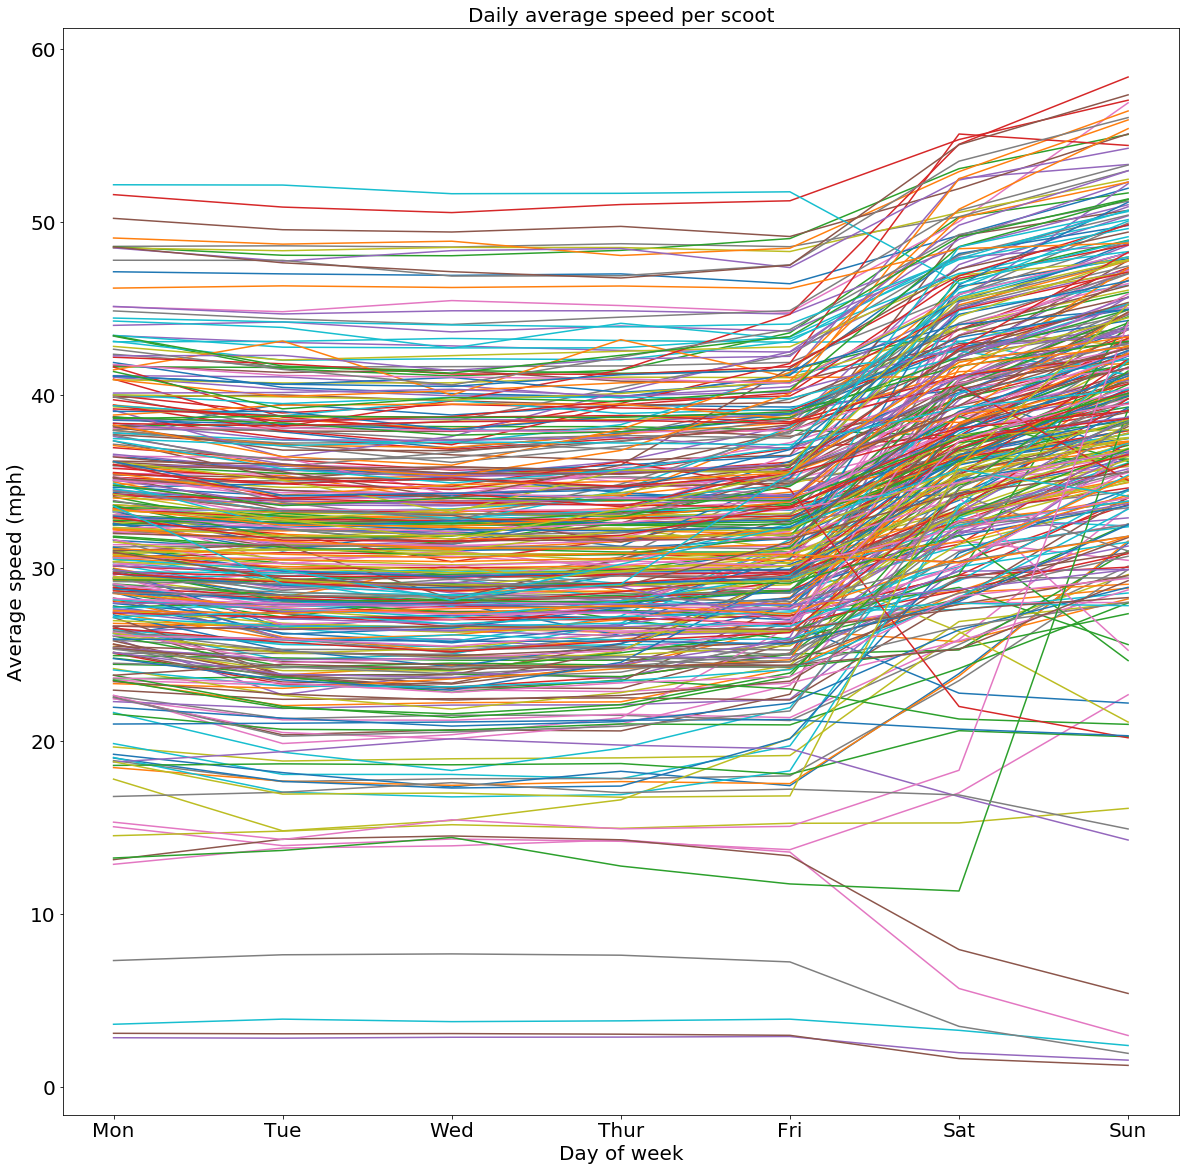

In [255]:
fig, ax = plt.subplots(figsize=(20,20))
plotme.T.plot(legend=False, ax=ax)
ax.set(xticks=range(7), xticklabels=labels)
ax.set_ylabel('Average speed (mph)')
ax.set_xlabel('Day of week')
ax.set_title('Daily average speed per scoot')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20);